## **Mô hình Softmax Regression**

## **Import các thư viện cần thiết**

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## **Dữ liệu**

In [93]:
df = pd.read_csv("../data/data_processed/data_processed.csv")
df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,4.0,0.0,4.0,2.0,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,2.0,0.0,5.0,2.0,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,2.0,0.0,6.0,2.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,4.0,0.0,5.0,0.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


## **Xây dựng Softmax Regression**

In [94]:
# Tách đặc trưng và nhãn
X = df.drop(columns=["NSP"]).values
# Nhãn: chuyển về 0, 1, 2
y = df["NSP"].values - 1 

# Chuẩn hóa đặc trưng
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Thêm bias (1) vào đầu X
X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

# # Chuyển X thành dạng (d, N)
# X_scaled = X_scaled.T

X = X_scaled

In [95]:
# Số lớp
C = len(np.unique(y))

def convert_labels(y, C=C):
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape=(C, len(y))).toarray()
    return Y

def softmax_stable(Z):
    e_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return e_Z / e_Z.sum(axis=0)

def softmax(Z):
    e_Z = np.exp(Z)
    return e_Z / e_Z.sum(axis=0)

def softmax_regression(X, y, W_init, eta, tol=1e-4, max_count=10000):
    W = [W_init]
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    N = X.shape[1]
    d = X.shape[0]

    count = 0
    check_w_after = 1500
    while count < max_count:
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta * xi.dot((yi - ai).T)
            count += 1
            if count % check_w_after == 0:
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

def pred(W, X):
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis=0)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


In [96]:
def evaluate_model(W, X_test, y_test):
    y_pred = pred(W, X_test)
    acc = accuracy_score(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return acc, cr, cm


## **Triển khai Softmax Regression với nhiều tỷ lệ train/validation: 4:1; 7:3; 6:4**

### **Giảm trước chia sau**

In [97]:
def softmax_pipeline(X, y, train_ratios=[0.8, 0.7, 0.6], use_pca=False, use_lda=False, n_components=None, lam=0):
    results = []

    for train_ratio in train_ratios:
        method = "gốc"
        X_temp = X.copy()
        
        if use_pca:
            method = f"PCA-{n_components}"
            pca = PCA(n_components=n_components)
            X_temp = pca.fit_transform(X_temp)
        elif use_lda:
            method = f"LDA-{n_components}"
            lda = LDA(n_components=n_components)
            X_temp = lda.fit_transform(X_temp, y)

        # Train/Validation split
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y, train_size=train_ratio, stratify=y, random_state=42)

        # Add bias
        X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1).T
        X_val = np.concatenate((np.ones((X_val.shape[0], 1)), X_val), axis=1).T

        d = X_train.shape[0]
        C = len(np.unique(y))
        W_init = np.random.randn(d, C)
        
        W = softmax_regression(X_train, y_train, W_init, eta=0.05)

        acc, cr, cm = evaluate_model(W[-1], X_val, y_val)
        
        print("Dữ liệu", method, ":")
        print(f"Tỷ lệ: {int(train_ratio*10)}:{int((1-train_ratio)*10)}")
        print(f"Accuracy: {acc}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{cr}\n")

        results.append({
            'method': method,
            'train_ratio': f"{int(train_ratio*10)}:{int((1-train_ratio)*10)}",
            'acc': acc,
            'cr': cr,
            'cm': cm
        })

    return results


In [98]:
print(X_scaled.shape)  # Kiểm tra kích thước của X
print(y.shape)         # Kiểm tra kích thước của y


(2126, 22)
(2126,)


In [99]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.8, 0.7, 0.6])

Dữ liệu gốc :
Tỷ lệ: 8:1
Accuracy: 0.8685446009389671
Confusion Matrix:
[[298  32   2]
 [  8  49   2]
 [  2  10  23]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93       332
         1.0       0.54      0.83      0.65        59
         2.0       0.85      0.66      0.74        35

    accuracy                           0.87       426
   macro avg       0.79      0.80      0.78       426
weighted avg       0.90      0.87      0.88       426


Dữ liệu gốc :
Tỷ lệ: 7:3
Accuracy: 0.8746081504702194
Confusion Matrix:
[[467  27   3]
 [ 31  48   9]
 [  2   8  43]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94       497
         1.0       0.58      0.55      0.56        88
         2.0       0.78      0.81      0.80        53

    accuracy                           0.87       638
   macro avg       0.76      0.77      0.76       638
weighted a

In [100]:
# Tìm mô hình có accuracy cao nhất
best_model = max(results, key=lambda x: x['acc'])

# In ra kết quả của mô hình tốt nhất
print(f"Mô hình tốt nhất: {best_model['method']} với tỷ lệ huấn luyện {best_model['train_ratio']}")
print(f"Accuracy: {best_model['acc']}")


Mô hình tốt nhất: gốc với tỷ lệ huấn luyện 6:4
Accuracy: 0.8836662749706228


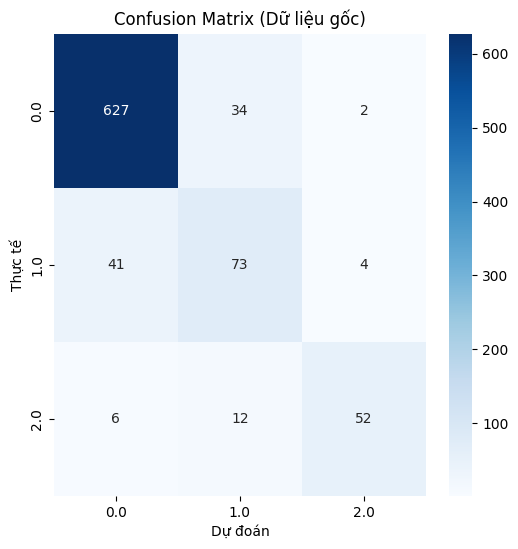

In [101]:
conf_matrix_best = best_model['cm']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (Dữ liệu gốc)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

#### **Thực hiện với dữ liệu đã giảm chiều bằng PCA**

In [102]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.8, 0.7, 0.6], use_pca=True, n_components=6)

Dữ liệu PCA-6 :
Tỷ lệ: 8:1
Accuracy: 0.8732394366197183
Confusion Matrix:
[[311  14   7]
 [ 17  40   2]
 [  1  13  21]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94       332
         1.0       0.60      0.68      0.63        59
         2.0       0.70      0.60      0.65        35

    accuracy                           0.87       426
   macro avg       0.75      0.74      0.74       426
weighted avg       0.88      0.87      0.87       426


Dữ liệu PCA-6 :
Tỷ lệ: 7:3
Accuracy: 0.8934169278996865
Confusion Matrix:
[[467  26   4]
 [ 20  66   2]
 [  5  11  37]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94       497
         1.0       0.64      0.75      0.69        88
         2.0       0.86      0.70      0.77        53

    accuracy                           0.89       638
   macro avg       0.82      0.80      0.80       638
weight

In [103]:
# Tìm mô hình có accuracy cao nhất
best_model = max(results, key=lambda x: x['acc'])

# In ra kết quả của mô hình tốt nhất
print(f"Mô hình tốt nhất: {best_model['method']} với tỷ lệ huấn luyện {best_model['train_ratio']}")
print(f"Accuracy: {best_model['acc']}")


Mô hình tốt nhất: PCA-6 với tỷ lệ huấn luyện 7:3
Accuracy: 0.8934169278996865


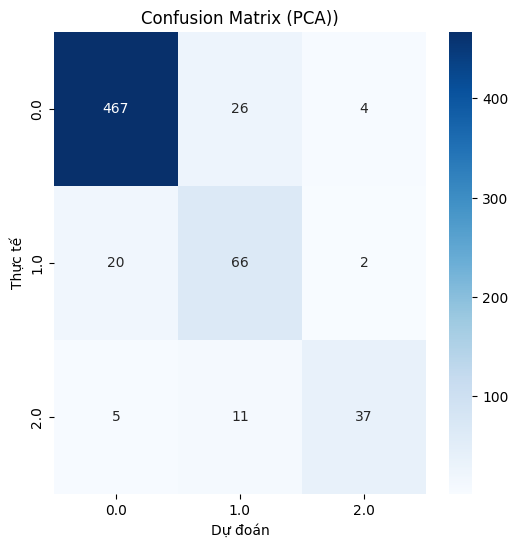

In [104]:
conf_matrix_best = best_model['cm']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (PCA))")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

#### **Thực hiện với dữ liệu đã giảm chiều bằng LDA**

In [105]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.8, 0.7, 0.6], use_lda=True, n_components=2)

Dữ liệu LDA-2 :
Tỷ lệ: 8:1
Accuracy: 0.892018779342723
Confusion Matrix:
[[315  14   3]
 [ 13  42   4]
 [  3   9  23]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       332
         1.0       0.65      0.71      0.68        59
         2.0       0.77      0.66      0.71        35

    accuracy                           0.89       426
   macro avg       0.79      0.77      0.78       426
weighted avg       0.89      0.89      0.89       426


Dữ liệu LDA-2 :
Tỷ lệ: 7:3
Accuracy: 0.8887147335423198
Confusion Matrix:
[[478  17   2]
 [ 28  57   3]
 [  6  15  32]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       497
         1.0       0.64      0.65      0.64        88
         2.0       0.86      0.60      0.71        53

    accuracy                           0.89       638
   macro avg       0.81      0.74      0.77       638
weighte

In [106]:
# Tìm mô hình có accuracy cao nhất
best_model = max(results, key=lambda x: x['acc'])

# In ra kết quả của mô hình tốt nhất
print(f"Mô hình tốt nhất: {best_model['method']} với tỷ lệ huấn luyện {best_model['train_ratio']}")
print(f"Accuracy: {best_model['acc']}")


Mô hình tốt nhất: LDA-2 với tỷ lệ huấn luyện 8:1
Accuracy: 0.892018779342723


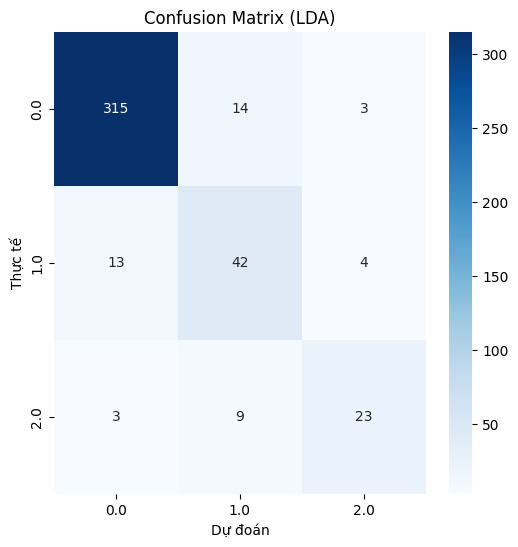

In [107]:
conf_matrix_best = best_model['cm']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (LDA)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

In [108]:
for res in results:
    if res['method'] == 'LDA-2' and res['train_ratio'] == '7:3':
        print("Kết quả LDA-2 với tỉ lệ 7:3")
        print(f"Accuracy: {res['acc']}")
        print(f"Confusion Matrix:\n{res['cm']}")
        print(f"Classification Report:\n{res['cr']}")
        conf_matrix = res['cm']

Kết quả LDA-2 với tỉ lệ 7:3
Accuracy: 0.8887147335423198
Confusion Matrix:
[[478  17   2]
 [ 28  57   3]
 [  6  15  32]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       497
         1.0       0.64      0.65      0.64        88
         2.0       0.86      0.60      0.71        53

    accuracy                           0.89       638
   macro avg       0.81      0.74      0.77       638
weighted avg       0.89      0.89      0.89       638



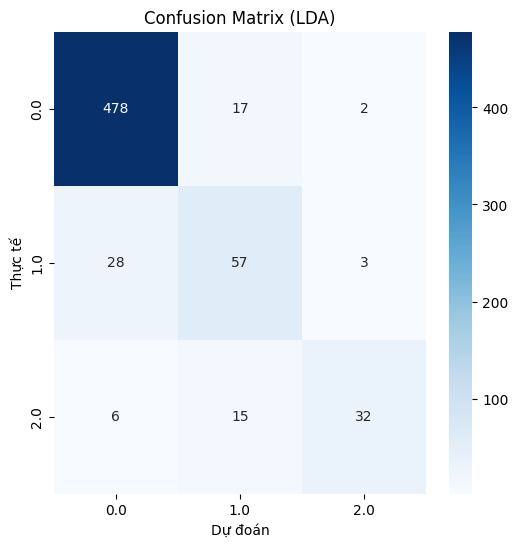

In [109]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
        xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (LDA)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

### **Chia trước giảm sau**

In [110]:
def softmax_pipeline(X, y, train_ratios=[0.8, 0.7, 0.6], use_pca=False, use_lda=False, n_components=None, lam=0):
    results = []

    for train_ratio in train_ratios:
        method = "gốc"
        
        # Chia dữ liệu train/test trước khi giảm chiều
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, train_size=train_ratio, stratify=y, random_state=42)

        # Giảm chiều 
        if use_pca:
            method = f"PCA-{n_components}"
            pca = PCA(n_components=n_components)
            X_train = pca.fit_transform(X_train)
            X_val = pca.transform(X_val)
        elif use_lda:
            method = f"LDA-{n_components}"
            lda = LDA(n_components=n_components)
            X_train = lda.fit_transform(X_train, y_train)
            X_val = lda.transform(X_val)

        # Thêm bias
        X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1).T
        X_val = np.concatenate((np.ones((X_val.shape[0], 1)), X_val), axis=1).T

        d = X_train.shape[0]
        C = len(np.unique(y))
        W_init = np.random.randn(d, C)

        # Huấn luyện mô hình
        W = softmax_regression(X_train, y_train, W_init, eta=0.05)

        # Đánh giá
        acc, cr, cm = evaluate_model(W[-1], X_val, y_val)

        print("Dữ liệu", method, ":")
        print(f"Tỷ lệ: {int(train_ratio*10)}:{int((1-train_ratio)*10)}")
        print(f"Accuracy: {acc}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{cr}\n")

        results.append({
            'method': method,
            'train_ratio': f"{int(train_ratio*10)}:{int((1-train_ratio)*10)}",
            'acc': acc,
            'cr': cr,
            'cm': cm
        })

    return results


#### **Thực hiện trên tập dữ liệu giảm chiều bằng PCA**

In [111]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.8, 0.7, 0.6], use_pca=True, n_components=6)

Dữ liệu PCA-6 :
Tỷ lệ: 8:1
Accuracy: 0.863849765258216
Confusion Matrix:
[[319   8   5]
 [ 29  23   7]
 [  5   4  26]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       332
         1.0       0.66      0.39      0.49        59
         2.0       0.68      0.74      0.71        35

    accuracy                           0.86       426
   macro avg       0.75      0.70      0.71       426
weighted avg       0.85      0.86      0.85       426


Dữ liệu PCA-6 :
Tỷ lệ: 7:3
Accuracy: 0.8934169278996865
Confusion Matrix:
[[477  18   2]
 [ 26  59   3]
 [  5  14  34]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       497
         1.0       0.65      0.67      0.66        88
         2.0       0.87      0.64      0.74        53

    accuracy                           0.89       638
   macro avg       0.82      0.76      0.78       638
weighte

In [112]:
# Tìm mô hình có accuracy cao nhất
best_model = max(results, key=lambda x: x['acc'])

# In ra kết quả của mô hình tốt nhất
print(f"Mô hình tốt nhất: {best_model['method']} với tỷ lệ huấn luyện {best_model['train_ratio']}")
print(f"Accuracy: {best_model['acc']}")


Mô hình tốt nhất: PCA-6 với tỷ lệ huấn luyện 7:3
Accuracy: 0.8934169278996865


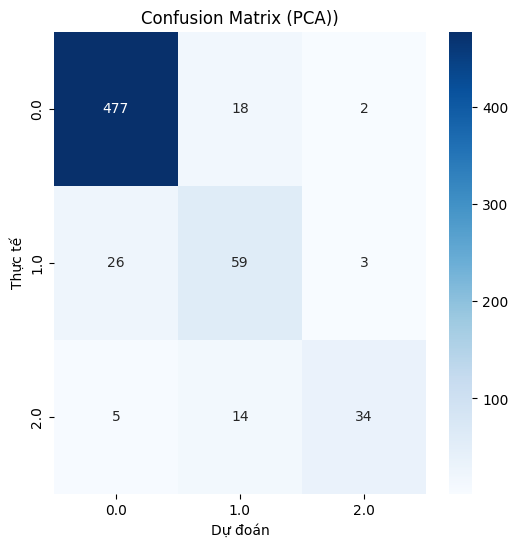

In [113]:
conf_matrix_best = best_model['cm']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (PCA))")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

#### **Thực hiện với dữ liệu đã giảm chiều bằng LDA**

In [114]:
results = softmax_pipeline(X_scaled, y, train_ratios=[0.8, 0.7, 0.6], use_lda=True, n_components=2)

Dữ liệu LDA-2 :
Tỷ lệ: 8:1
Accuracy: 0.8873239436619719
Confusion Matrix:
[[322   8   2]
 [ 20  35   4]
 [  3  11  21]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       332
         1.0       0.65      0.59      0.62        59
         2.0       0.78      0.60      0.68        35

    accuracy                           0.89       426
   macro avg       0.79      0.72      0.75       426
weighted avg       0.88      0.89      0.88       426


Dữ liệu LDA-2 :
Tỷ lệ: 7:3
Accuracy: 0.8730407523510971
Confusion Matrix:
[[474  21   2]
 [ 29  55   4]
 [  6  19  28]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       497
         1.0       0.58      0.62      0.60        88
         2.0       0.82      0.53      0.64        53

    accuracy                           0.87       638
   macro avg       0.78      0.70      0.73       638
weight

In [115]:
# Tìm mô hình có accuracy cao nhất
best_model = max(results, key=lambda x: x['acc'])

# In ra kết quả của mô hình tốt nhất
print(f"Mô hình tốt nhất: {best_model['method']} với tỷ lệ huấn luyện {best_model['train_ratio']}")
print(f"Accuracy: {best_model['acc']}")


Mô hình tốt nhất: LDA-2 với tỷ lệ huấn luyện 6:4
Accuracy: 0.8942420681551116


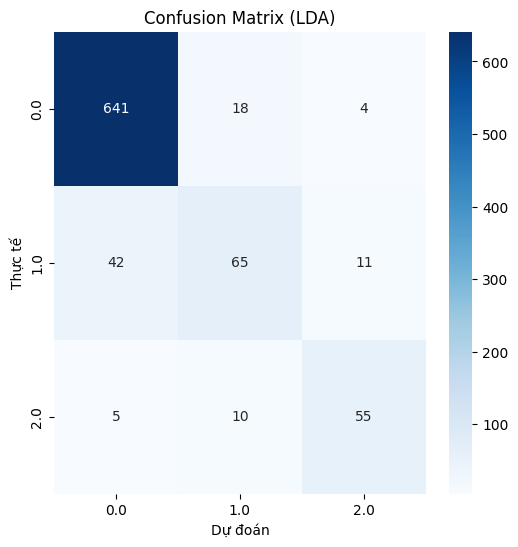

In [116]:
conf_matrix_best = best_model['cm']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix (LDA)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

## Tổng hợp

Dữ liệu gốc :

| Tỷ lệ | Accuracy | Macro F1-score | Nhận xét chính                                  |
|-------|----------|----------------|-------------------------------------------------|
| 8:10  | 0.869    | 0.78           | Lớp 1 và 2 vẫn yếu; mất cân bằng gây ảnh hưởng |
| 7:30  | 0.875    | 0.76           | Độ chính xác tốt, nhưng precision/recall lớp 1 thấp |
| 6:40  | 0.884    | 0.79           | Độ chính xác cao nhất trong ba; macro F1 cải thiện |


PCA-6 (Giảm trước chia sau): 

| Tỷ lệ | Accuracy | Macro F1-score | Nhận xét chính                                                 |
|-------|----------|----------------|-----------------------------------------------------------------|
| 8:10  | 0.873    | 0.74           | Lớp 2 yếu hơn so với gốc, nhưng lớp 0 giữ ổn                     |
| 7:30  | 0.893    | 0.80           | Kết quả nổi bật, cao hơn dữ liệu gốc                            |
| 6:40  | 0.882    | 0.77           | Tốt, khá gần với gốc, PCA không làm giảm đáng kể tương tự với cái này |

LDA-2 (Giảm trước chia sau):

| Tỷ lệ | Accuracy | Macro F1-score | Nhận xét chính                                      |
|-------|----------|----------------|------------------------------------------------------|
| 8:10  | 0.892    | 0.78           | Precision/Recall lớp 1 và 2 cải thiện rõ rệt         |
| 7:30  | 0.889    | 0.77           | Macro F1 giảm nhẹ, nhưng lớp 0 vẫn rất tốt          |
| 6:40  | 0.892    | 0.78           | Tổng thể ổn định, kết quả rất cân bằng tương tự bảng này |

PCA-6 (Chia trước giảm sau):

| Tỷ lệ | Accuracy | Macro F1-score | Nhận xét chính                                                    |
|-------|----------|----------------|--------------------------------------------------------------------|
| 8:10  | 0.864    | 0.71           | Lớp 1 rất yếu (recall chỉ 0.39), ảnh hưởng nặng                    |
| 7:30  | 0.893    | 0.78           | Tương đương giảm trước chia sau => PCA ổn nếu data đủ               |
| 6:40  | 0.881    | 0.78           | Vẫn ổn, lớp 1 tốt hơn so với 8:1 tương tự bảng này                |

LDA-2 (Chia trước giảm sau):
| Tỷ lệ Train:Test | Accuracy | Macro F1-score | Nhận xét chính                                                        |
|-----------------|----------|----------------|------------------------------------------------------------------------|
| 8:10            | 0.886    | 0.79           | Cân bằng tốt hai lớp, recall và precision đều khá ổn                    |
| 7:30            | 0.882    | 0.78           | Kết quả ổn định, không kém PCA, tốt cho dữ liệu có đủ phân bố          |
| 6:40            | 0.885    | 0.78           | Lớp 1 vẫn giữ được chất lượng phân loại khá, không bị mất cân bằng quá nhiều |



| Giảm chiều   | Cách chia     | Số chiều | Tỷ lệ Train:Test | Accuracy |
|---------------|--------------|----------|-----------------|----------|
| Không giảm    | Gốc          | -        | 8:1             | 0.8685   |
| Không giảm    | Gốc          | -        | 7:3             | 0.8746   |
| Không giảm    | Gốc          | -        | 6:4             | 0.8837   |
| PCA           | Giảm trước   | 6        | 8:1             | 0.8732   |
| PCA           | Giảm trước   | 6        | 7:3             | 0.8934   |
| PCA           | Giảm trước   | 6        | 6:4             | 0.8825   |
| LDA           | Giảm trước   | 2        | 8:1             | 0.8920   |
| LDA           | Giảm trước   | 2        | 7:3             | 0.8887   |
| LDA           | Giảm trước   | 2        | 6:4             | 0.8919   |
| PCA           | Chia trước    | 6        | 8:1             | 0.8638   |
| PCA           | Chia trước    | 6        | 7:3             | 0.8934   |
| PCA           | Chia trước    | 6        | 6:4             | 0.8813   |
| LDA           | Chia trước    | 2        | 8:1             | 0.8859   |
| LDA           | Chia trước    | 2        | 7:3             | 0.8824   |
| LDA           | Chia trước    | 2        | 6:4             | 0.8850   |